In [1]:

%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

/home/kdang/projects/spartDM
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
from src.data.datamodules.starmen import StarmenDataset
from monai.data import DataLoader
from src.sadm.utils import plot_multi_imgs
from src.utils.metrics import percnorm, mse, mae
import json
import torch
import torch.nn.functional as F
from monai.transforms import ScaleIntensity
from einops import rearrange
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from src.utils.visualization import filter_gt_ano_region
import torchvision
from src.utils.visualization import plot_comparison_starmen, plot_kde_pixel, draw_featmap
from src.ldae.utils import heat_map, feature_distance, patchify

from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constant variables and helper functions

DATA_DIR = "data/starmen/output_random_noacc"
WORK_DIR = "workdir/diffae_starmen"


# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

def convert_to_torch(x, add_color_channel=True, device=torch.device("cpu")):
    """
    convert a numpy array to torch.Tensor with option to add C channel
    """
    if add_color_channel:
        x = rearrange(x, "b h w -> b 1 h w")
    x = torch.tensor(x, dtype=torch.float32).to(device)
    return x

to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Load model

In [3]:
# CondDDPM model

from src.ldae import CondDDPM
from lightning.pytorch.utilities.model_summary import ModelSummary


## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)
ema_encoder = diffae_litmodel.ema_encoder
ema_encoder.eval()
ema_decoder = diffae_litmodel.ema_decoder
ema_decoder.eval()
gaussian_diffusion = diffae_litmodel.gaussian_diffusion

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | decoder     | CondUNet        | 2.5 M  | train
1 | encoder     | SemanticEncoder | 24.6 M | train
2 | ema_encoder | SemanticEncoder | 24.6 M | eval 
3 | ema_decoder | CondUNet        | 2.5 M  | eval 
--------------------------------------------------------
27.1 M    Trainable params
27.1 M    Non-trainable params
54.1 M    Total params
216.547   Total estimated model params size (MB)
492       Modules in train mode
492       Modules in eval mode


# Load ds: growing_circle20

In [9]:
# Reload the data 
import json

split = "growing_circle20"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

# Test dataset
test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
print(f"Len of test dataset: {len(test_loader)}")


# Read the reconstruction error files to get the index and corresponding reonconstruction image
try: 
    eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
    with open(eval_result_file, "r") as f:
        eval_dict = json.load(f)
    test_ids = eval_dict["IDs"]
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
except FileNotFoundError:
    test_ids = test_ds.ids

test_ids

# Load the original (anomalious) image from test dataset by index
x_orgs = [test_ds.get_images_by_id(id)["img"].squeeze() for id in test_ids]
x_orgs = np.stack(x_orgs).astype("float32")

# Load the groundtruth anomaly mask 
x_ano_gts = []
for id in test_ds.ids:
    x_ano_gt = test_ds.get_images_by_id(id)["anomaly_gt_seg"]

    if x_ano_gt is None:
        break
    else:
        x_ano_gts.append(x_ano_gt.squeeze())

if len(x_ano_gts) > 0: 
    x_ano_gts = np.stack(x_ano_gts).astype("float32")
x_ano_gts.shape

# Load the original healthy images
# healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
x_hts = []
for id in test_ids:
    for t in range(0, 10):
        ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
        ht = np.load(ht_path)
        x_hts.append(ht)
x_hts = np.stack(x_hts)
x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
x_hts.shape

# add C dimension
x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")
x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")

# Load reconstruction - xT_inferred
x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
x_recons.shape

# Load reconstruction - from random noise
x_recons_semantic = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
x_recons_semantic.shape

# convert to torch

x_orgs = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
x_hts = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
x_ano_gts = to_torch(x_ano_gts) if not isinstance(x_ano_gts, torch.Tensor) else x_ano_gts
x_recons = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons
x_recons_semantic = to_torch(x_recons_semantic) if not isinstance(x_recons_semantic, torch.Tensor) else x_recons_semantic

Len of test dataset: 20


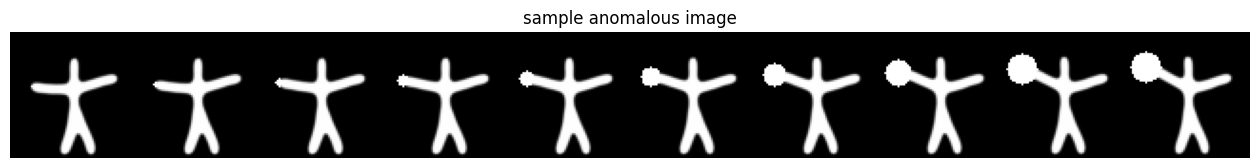

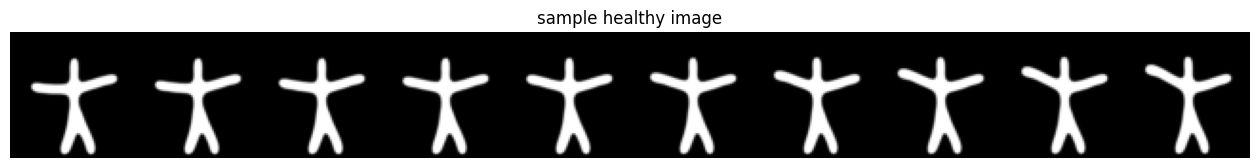

In [10]:
## Choose a sample image
i = 1
x0_ano = x_orgs[i]
x0_ht = x_hts[i]
x0_ano_gt = x_ano_gts[i]

quick_plot_tensor(x0_ano, "sample anomalous image")
quick_plot_tensor(x0_ht, "sample healthy image")

## Image interpolation


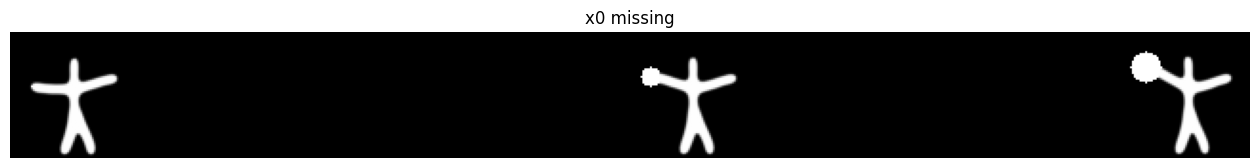

In [17]:
# Select image from different timeframe of the same patient
import copy

missing_idx = [1, 2, 3, 4, 6, 7, 8]
x0_miss = copy.deepcopy(x0_ano)
x0_miss[missing_idx] = torch.zeros_like(x0_ano[0])

quick_plot_tensor(x0_miss, "x0 missing")

## lerp-slerp mode

In [37]:
ddim_style = "ddim20"

x0_recon = copy.deepcopy(x0_miss)
xprev = x0_recon[0]
prev_idx = 0

for i in range(10):
    x = x0_recon[i]

    if torch.all(x == 0):
        # find next observed data
        for j in range(i+1, 10):
            if not torch.all(x0_recon[j] == 0):
                xnext = x0_recon[j]
                next_idx = j
                break

        # perform lerp-slerp interpolation 
        print(f"Interpolation for idx: {i} - prev_idx: {prev_idx} - next_idx: {next_idx}")
        alpha = (i - prev_idx) / (next_idx - prev_idx)
        out = gaussian_diffusion.lerp_slerp_interpolation(
                ddim_encode=ddim_style,
                ddim_decode=ddim_style,
                encoder=ema_encoder,
                decoder=ema_decoder,
                x_0=xprev.unsqueeze(0),
                x_1=xnext.unsqueeze(1),
                z_0=None,
                z_1=None,
                alpha=alpha,
                disable_tqdm=False,
                noise_level=250
            )
        x0_recon[i] = out["x"]
    else:
        xprev = x
        prev_idx = i


Interpolation for idx: 1 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.89it/s]


Interpolation for idx: 2 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 17.39it/s]


Interpolation for idx: 3 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.39it/s]


Interpolation for idx: 4 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 17.71it/s]


Interpolation for idx: 6 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 19.40it/s]


Interpolation for idx: 7 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 20/20 [00:00<00:00, 21.13it/s]


Interpolation for idx: 8 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 19.40it/s]


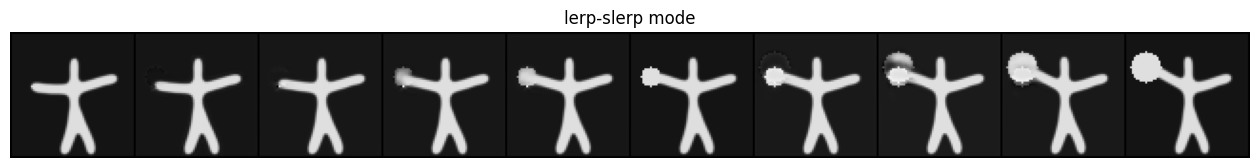

In [38]:
quick_plot_tensor(x0_recon, "lerp-slerp mode")

## lerp-lerp mode


In [35]:
ddim_style = "ddim20"

x0_recon2 = copy.deepcopy(x0_miss)
xprev = x0_recon2[0]
prev_idx = 0

for i in range(10):
    x = x0_recon2[i]

    if torch.all(x == 0):
        # find next observed data
        for j in range(i+1, 10):
            if not torch.all(x0_recon2[j] == 0):
                xnext = x0_recon2[j]
                next_idx = j
                break

        # perform lerp-slerp interpolation 
        print(f"Interpolation for idx: {i} - prev_idx: {prev_idx} - next_idx: {next_idx}")
        alpha = (i - prev_idx) / (next_idx - prev_idx)
        out = gaussian_diffusion.lerp_slerp_interpolation(
                ddim_encode=ddim_style,
                ddim_decode=ddim_style,
                encoder=ema_encoder,
                decoder=ema_decoder,
                x_0=xprev.unsqueeze(0),
                x_1=xnext.unsqueeze(1),
                z_0=None,
                z_1=None,
                alpha=alpha,
                disable_tqdm=False,
                noise_level=250,
                mode=["lerp", "lerp"]
            )
        x0_recon2[i] = out["x"]
    else:
        xprev = x
        prev_idx = i


Interpolation for idx: 1 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 19.27it/s]


Interpolation for idx: 2 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 19.47it/s]


Interpolation for idx: 3 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.40it/s]


Interpolation for idx: 4 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.32it/s]


Interpolation for idx: 6 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.03it/s]


Interpolation for idx: 7 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.16it/s]


Interpolation for idx: 8 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 20/20 [00:01<00:00, 18.73it/s]


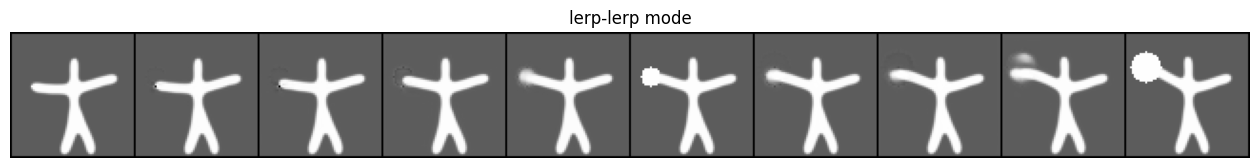

In [36]:
quick_plot_tensor(x0_recon2, "lerp-lerp mode")

# Healthy test ds


In [4]:
# Reload the data 
import json

split = "test"
infer_dir = os.path.join(WORK_DIR, "infer", f"{split}_ddim100_noise250")

# Test dataset
test_ds = StarmenDataset(
    data_dir=DATA_DIR,
    split=split,
    nb_subject=None,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)
print(f"Len of test dataset: {len(test_loader)}")


# Read the reconstruction error files to get the index and corresponding reonconstruction image
try: 
    eval_result_file = os.path.join(infer_dir, "results", "eval_dict.json")
    with open(eval_result_file, "r") as f:
        eval_dict = json.load(f)
    test_ids = eval_dict["IDs"]
    # test_ids = np.load(recons_idx_path)
    # test_ids = test_ids.squeeze().tolist()
except FileNotFoundError:
    test_ids = test_ds.ids

test_ids

# Load the original (anomalious) image from test dataset by index
x_orgs = [test_ds.get_images_by_id(id)["img"].squeeze() for id in test_ids]
x_orgs = np.stack(x_orgs).astype("float32")

# Load the groundtruth anomaly mask 
x_ano_gts = []
for id in test_ds.ids:
    x_ano_gt = test_ds.get_images_by_id(id)["anomaly_gt_seg"]

    if x_ano_gt is None:
        break
    else:
        x_ano_gts.append(x_ano_gt.squeeze())

if len(x_ano_gts) > 0: 
    x_ano_gts = np.stack(x_ano_gts).astype("float32")
    x_ano_gts.shape

# Load the original healthy images
# healthy path example= data/starmen/output_random_noacc/images/SimulatedData__Reconstruction__starman__subject_s0__tp_0.npy
x_hts = []
for id in test_ids:
    for t in range(0, 10):
        ht_path = os.path.join(DATA_DIR, "images", f"SimulatedData__Reconstruction__starman__subject_s{id}__tp_{t}.npy")
        ht = np.load(ht_path)
        x_hts.append(ht)
x_hts = np.stack(x_hts)
x_hts = rearrange(x_hts, "(b t) h w -> b t h w", t=10)
x_hts.shape

# add C dimension
x_orgs = rearrange(x_orgs, "b t h w -> b t 1 h w")
x_hts = rearrange(x_hts, "b t h w -> b t 1 h w")
if len(x_ano_gts) > 0:
    x_ano_gts = rearrange(x_ano_gts, "b t h w -> b t 1 h w")


# Load reconstruction - xT_inferred
x_recons = np.load(os.path.join(infer_dir, "results", "recons.npy"))
x_recons.shape

# Load reconstruction - from random noise
x_recons_semantic = np.load(os.path.join(infer_dir, "results", "recons_semantic.npy"))
x_recons_semantic.shape

# convert to torch

x_orgs = to_torch(x_orgs) if not isinstance(x_orgs, torch.Tensor) else x_orgs
x_hts = to_torch(x_hts) if not isinstance(x_hts, torch.Tensor) else x_hts
x_ano_gts = to_torch(x_ano_gts) if not isinstance(x_ano_gts, torch.Tensor) else x_ano_gts
x_recons = to_torch(x_recons) if not isinstance(x_recons, torch.Tensor) else x_recons
x_recons_semantic = to_torch(x_recons_semantic) if not isinstance(x_recons_semantic, torch.Tensor) else x_recons_semantic

Len of test dataset: 150


## lerp-slerp interpolation

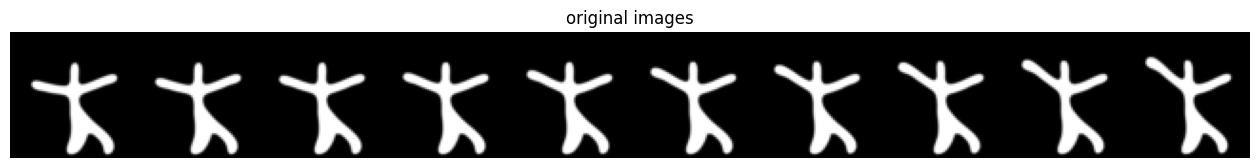

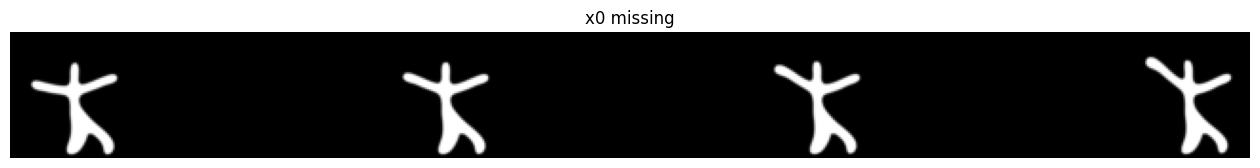

In [14]:
# Select image from different timeframe of the same patient
import copy

## Choose a sample image
i = 1
x0_ano = x_orgs[i]
x0_ht = x_hts[i]


missing_idx = [1, 2, 4, 5, 7, 8]
x0_miss = copy.deepcopy(x0_ano)
x0_miss[missing_idx] = torch.zeros_like(x0_ano[0])

quick_plot_tensor(x0_ano, "original images")
quick_plot_tensor(x0_miss, "x0 missing")

In [15]:
ddim_style = "ddim100"

x0_recon = copy.deepcopy(x0_miss)
xprev = x0_recon[0]
prev_idx = 0

for i in range(10):
    x = x0_recon[i]

    if torch.all(x == 0):
        # find next observed data
        for j in range(i+1, 10):
            if not torch.all(x0_recon[j] == 0):
                xnext = x0_recon[j]
                next_idx = j
                break

        # perform lerp-slerp interpolation 
        print(f"Interpolation for idx: {i} - prev_idx: {prev_idx} - next_idx: {next_idx}")
        alpha = (i - prev_idx) / (next_idx - prev_idx)
        out = gaussian_diffusion.lerp_slerp_interpolation(
                ddim_encode=ddim_style,
                ddim_decode=ddim_style,
                encoder=ema_encoder,
                decoder=ema_decoder,
                x_0=xprev.unsqueeze(0),
                x_1=xnext.unsqueeze(1),
                z_0=None,
                z_1=None,
                alpha=alpha,
                disable_tqdm=False,
                noise_level=250
            )
        x0_recon[i] = out["x"]
    else:
        xprev = x
        prev_idx = i


Interpolation for idx: 1 - prev_idx: 0 - next_idx: 3


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 17.59it/s]


Interpolation for idx: 2 - prev_idx: 0 - next_idx: 3


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 19.61it/s]


Interpolation for idx: 4 - prev_idx: 3 - next_idx: 6


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


Interpolation for idx: 5 - prev_idx: 3 - next_idx: 6


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 19.72it/s]


Interpolation for idx: 7 - prev_idx: 6 - next_idx: 9


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 19.70it/s]


Interpolation for idx: 8 - prev_idx: 6 - next_idx: 9


sampling loop time step: 100%|██████████| 100/100 [00:05<00:00, 18.82it/s]


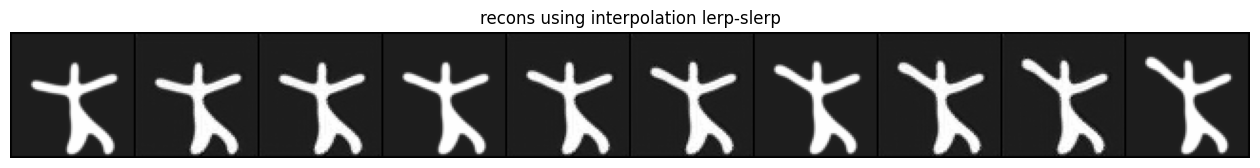

In [70]:
quick_plot_tensor(x0_recon, "recons using interpolation lerp-slerp")

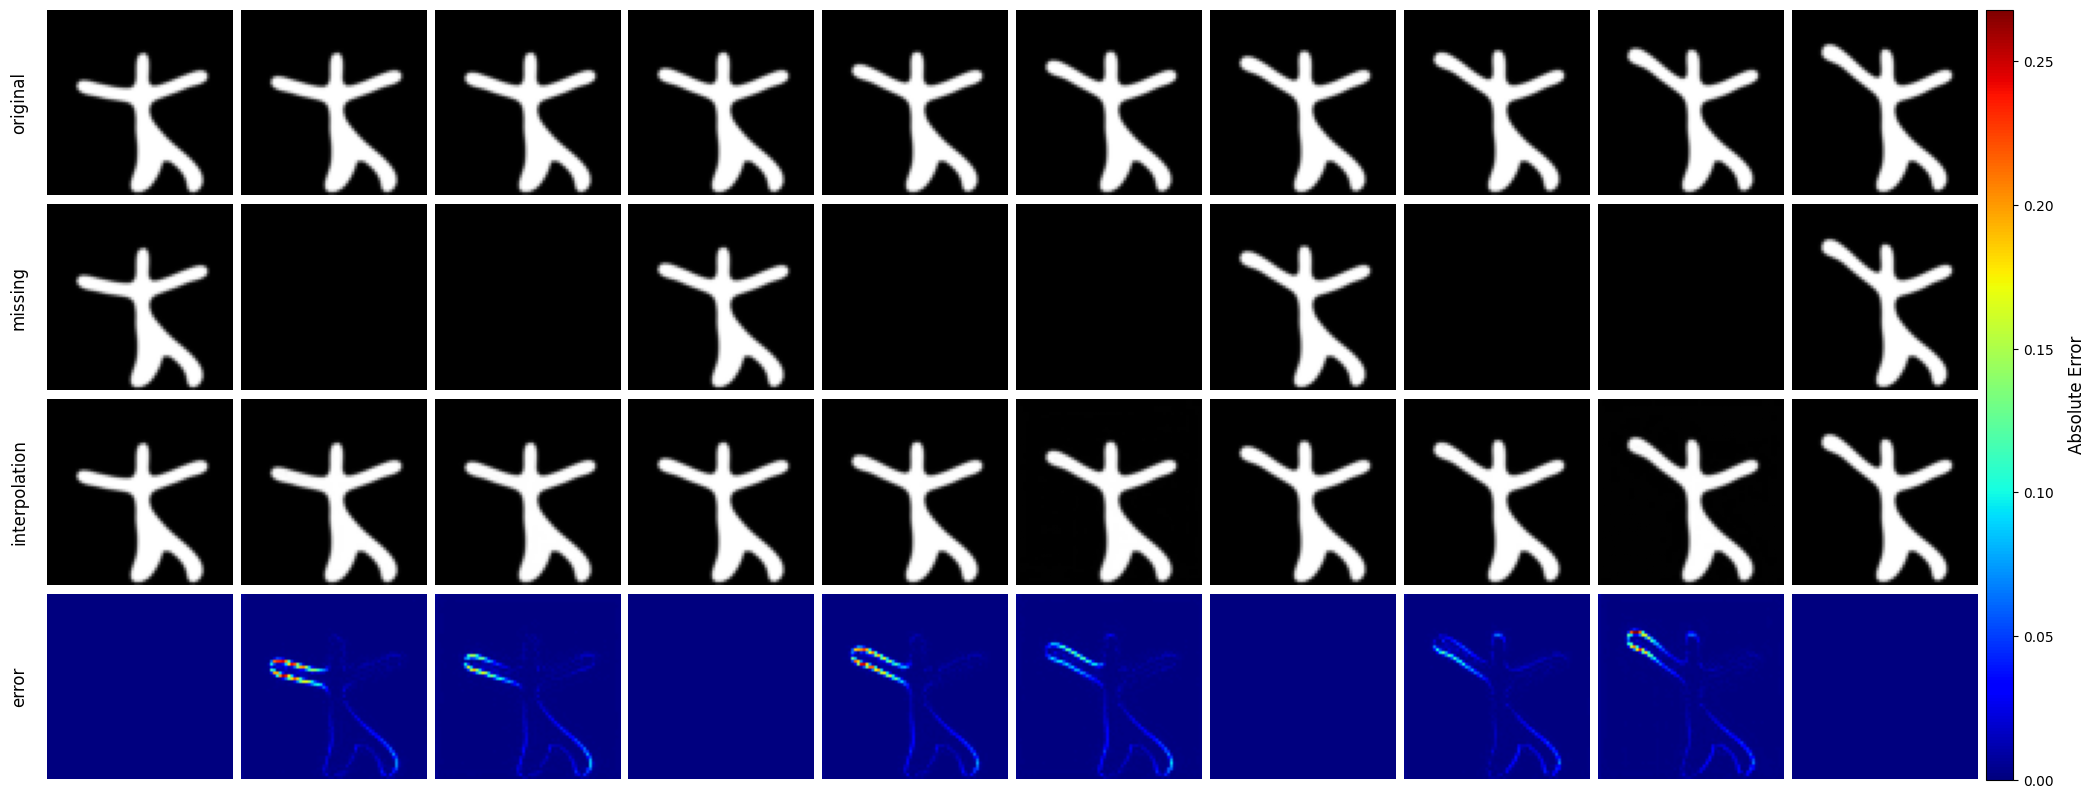

In [16]:
diff = torch.abs(x0_ano - x0_recon).squeeze()

fig = plot_comparison_starmen(
    imgs=[x0_ano.squeeze(), x0_miss.squeeze(), x0_recon.squeeze(), diff],
    labels=["original", "missing", "interpolation", "error"],
    is_errors=[False, False, False, True],
    same_cbar=True
)

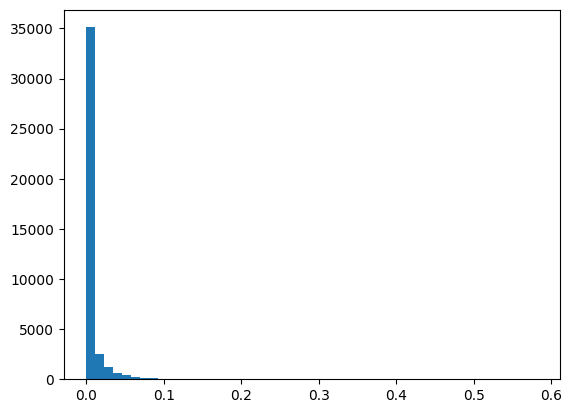

In [67]:
# Plot error histogram

diff_np = diff.cpu().numpy().flatten()
diff_np.shape

import seaborn as sns
plt.hist(diff_np, bins=50)
plt.show()

## Fewer observed data


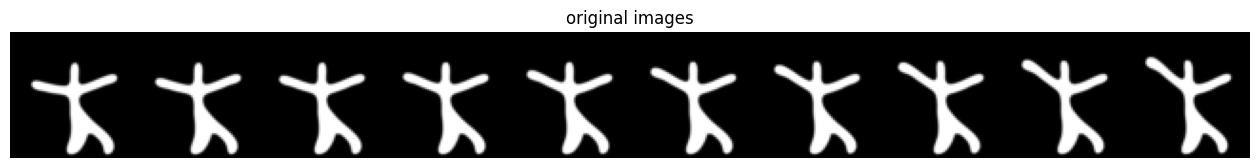

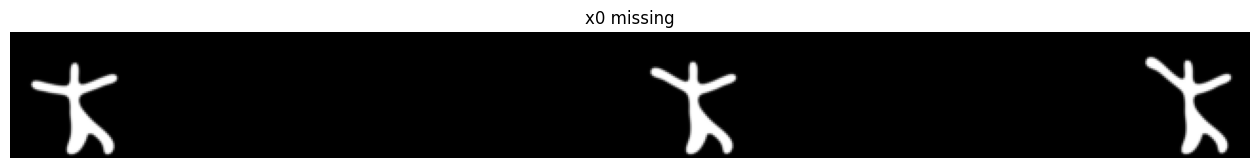

In [17]:
## Choose a sample image
i = 1
x0_ano = x_orgs[i]
x0_ht = x_hts[i]


missing_idx = [1, 2, 3, 4, 6, 7, 8]
x0_miss = copy.deepcopy(x0_ano)
x0_miss[missing_idx] = torch.zeros_like(x0_ano[0])

quick_plot_tensor(x0_ano, "original images")
quick_plot_tensor(x0_miss, "x0 missing")

In [18]:
ddim_style = "ddim100"

x0_recon = copy.deepcopy(x0_miss)
xprev = x0_recon[0]
prev_idx = 0

for i in range(10):
    x = x0_recon[i]

    if torch.all(x == 0):
        # find next observed data
        for j in range(i+1, 10):
            if not torch.all(x0_recon[j] == 0):
                xnext = x0_recon[j]
                next_idx = j
                break

        # perform lerp-slerp interpolation 
        print(f"Interpolation for idx: {i} - prev_idx: {prev_idx} - next_idx: {next_idx}")
        alpha = (i - prev_idx) / (next_idx - prev_idx)
        out = gaussian_diffusion.lerp_slerp_interpolation(
                ddim_encode=ddim_style,
                ddim_decode=ddim_style,
                encoder=ema_encoder,
                decoder=ema_decoder,
                x_0=xprev.unsqueeze(0),
                x_1=xnext.unsqueeze(1),
                z_0=None,
                z_1=None,
                alpha=alpha,
                disable_tqdm=False,
                noise_level=250
            )
        x0_recon[i] = out["x"]
    else:
        xprev = x
        prev_idx = i


Interpolation for idx: 1 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 20.76it/s]


Interpolation for idx: 2 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


Interpolation for idx: 3 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 21.42it/s]


Interpolation for idx: 4 - prev_idx: 0 - next_idx: 5


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 22.86it/s]


Interpolation for idx: 6 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 21.54it/s]


Interpolation for idx: 7 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 21.93it/s]


Interpolation for idx: 8 - prev_idx: 5 - next_idx: 9


sampling loop time step: 100%|██████████| 100/100 [00:04<00:00, 22.54it/s]


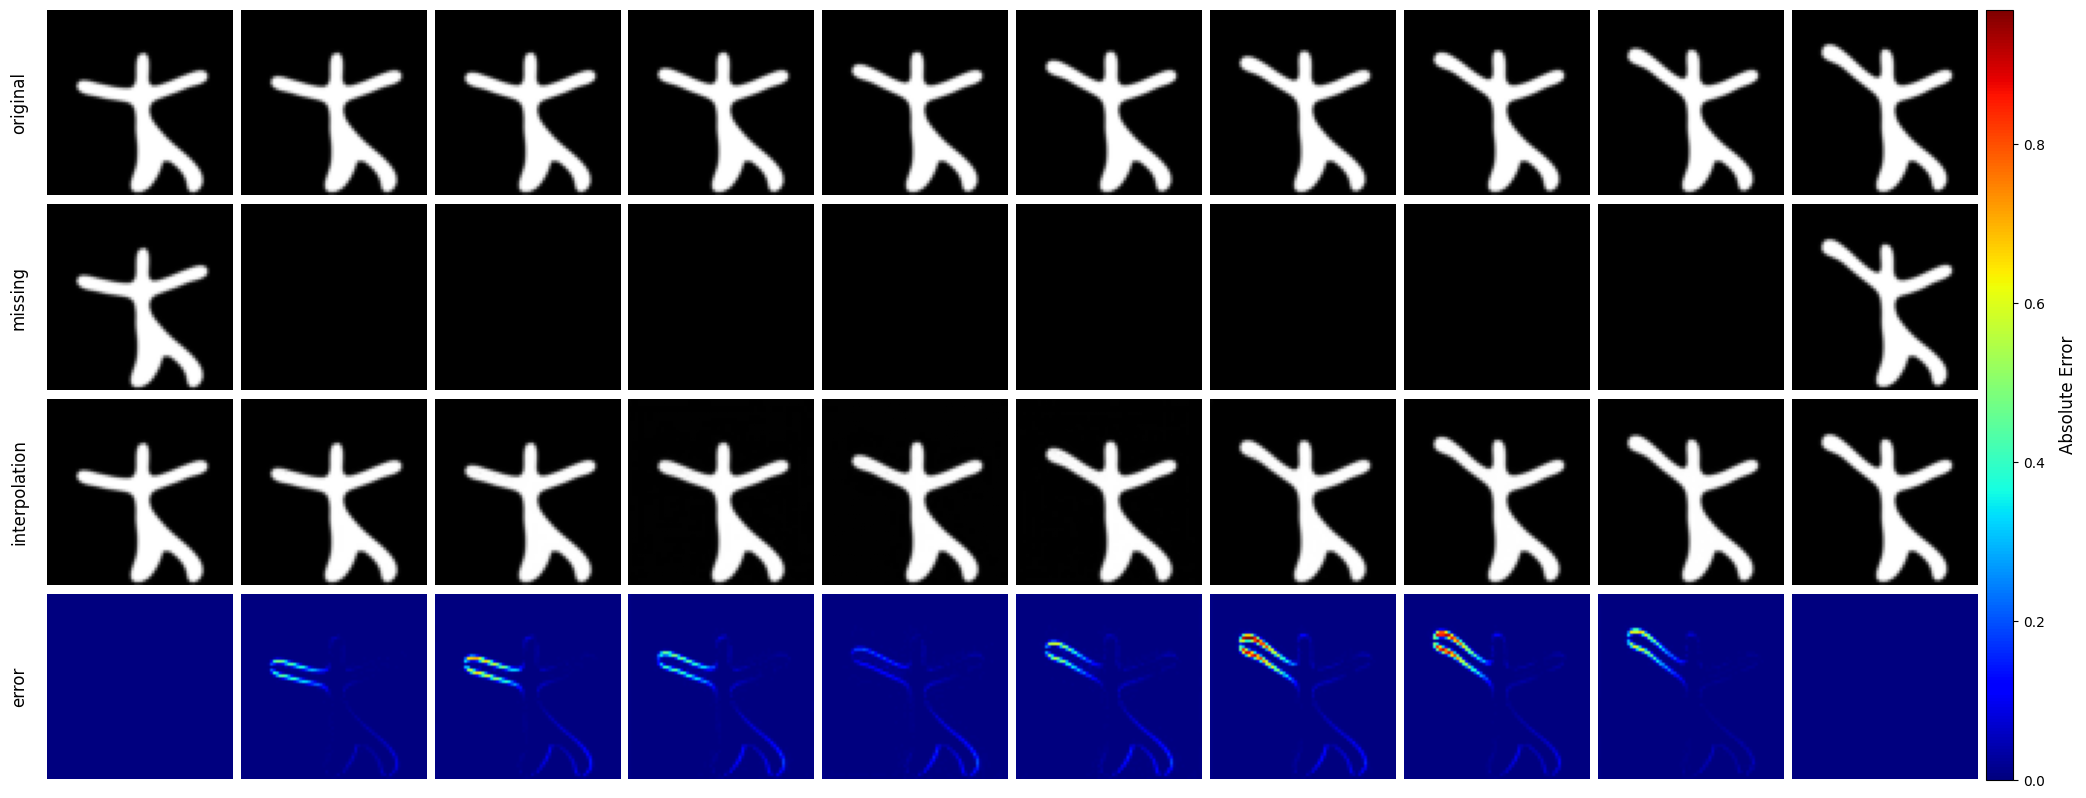

In [13]:
diff = torch.abs(x0_ano - x0_recon).squeeze()

fig = plot_comparison_starmen(
    imgs=[x0_ano.squeeze(), x0_miss.squeeze(), x0_recon.squeeze(), diff],
    labels=["original", "missing", "interpolation", "error"],
    is_errors=[False, False, False, True],
    same_cbar=True
)

# Test

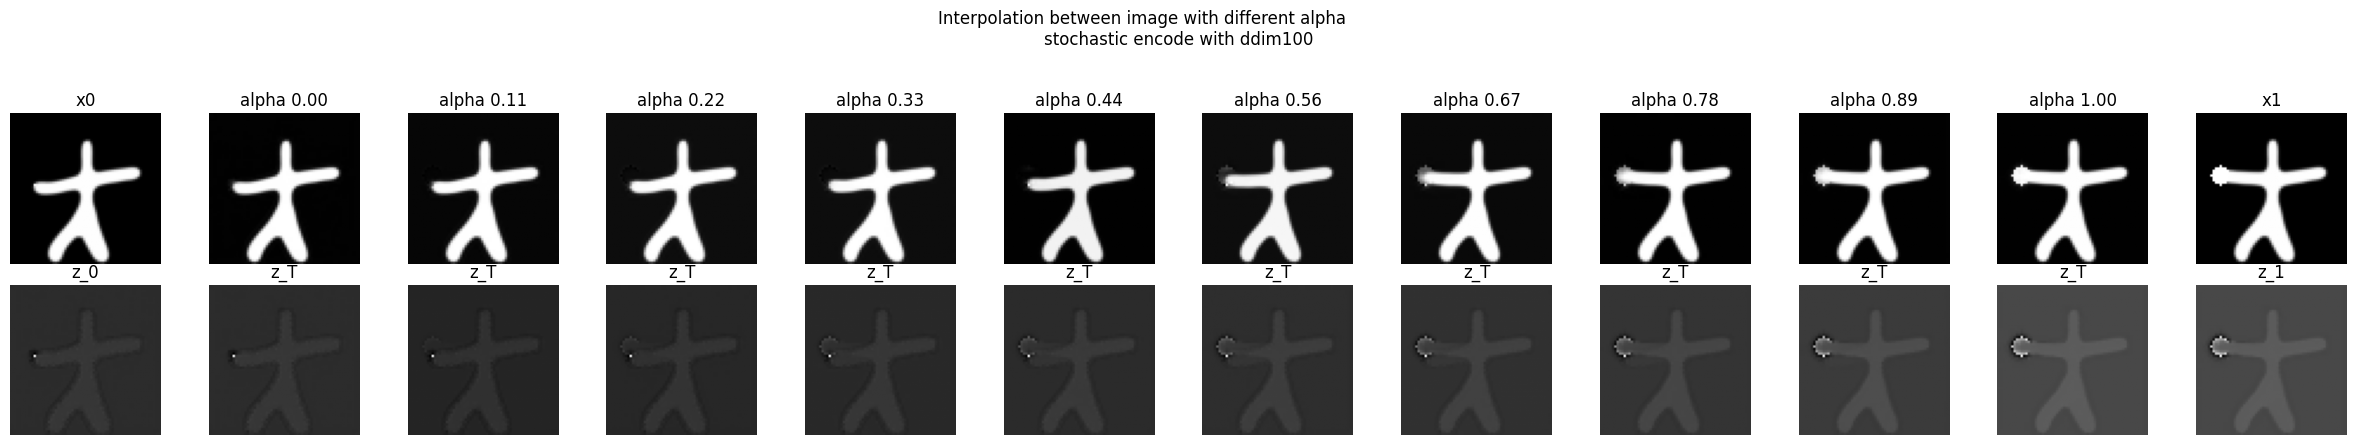

In [438]:
ncol = len(x_interpolated) + 2
nrow = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(2. * ncol, 2.1 *nrow))

# x0 image
ax = axes[0, 0]
ax.imshow(x0.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x0")

ax = axes[1, 0]
ax.imshow(out["z_0"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_0")

# x1 image
ax = axes[0, -1]
ax.imshow(x1.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x1")

ax = axes[1, -1]
ax.imshow(out["z_1"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_1")

# interpolation image
for i, img in enumerate(x_interpolated):
    
    ax = axes[0, i+1]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"alpha {alpha[i]:.2f}")

    ax = axes[1, i+1]
    ax.imshow(zT[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"z_T")

plt.suptitle(f"Interpolation between image with different alpha \
             \nstochastic encode with {ddim_style}", y=1.05)
plt.tight_layout()
plt.show()

## lerp-lerp mode

In [440]:
alpha = np.linspace(0., 1., 10)
x_interpolated = []
zT = []
ddim_style = "ddim10"


for a in alpha: 
    print(f"Start interpolation with alpha = {a}")
    out = gaussian_diffusion.lerp_slerp_interpolation(
            ddim_encode=ddim_style,
            ddim_decode=ddim_style,
            encoder=ema_encoder,
            decoder=ema_decoder,
            x_0=x0,
            x_1=x1,
            z_0=None,
            z_1=None,
            alpha=a,
            disable_tqdm=False,
            noise_level=100,
            mode=["lerp", "lerp"]
        )
    x_interpolated.append(out["x"].squeeze())
    zT.append(out["z_T"].squeeze())

Start interpolation with alpha = 0.0


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s]


Start interpolation with alpha = 0.1111111111111111


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.58it/s]


Start interpolation with alpha = 0.2222222222222222


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


Start interpolation with alpha = 0.3333333333333333


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s]


Start interpolation with alpha = 0.4444444444444444


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.22it/s]


Start interpolation with alpha = 0.5555555555555556


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s]


Start interpolation with alpha = 0.6666666666666666


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.94it/s]


Start interpolation with alpha = 0.7777777777777777


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s]


Start interpolation with alpha = 0.8888888888888888


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s]


Start interpolation with alpha = 1.0


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s]


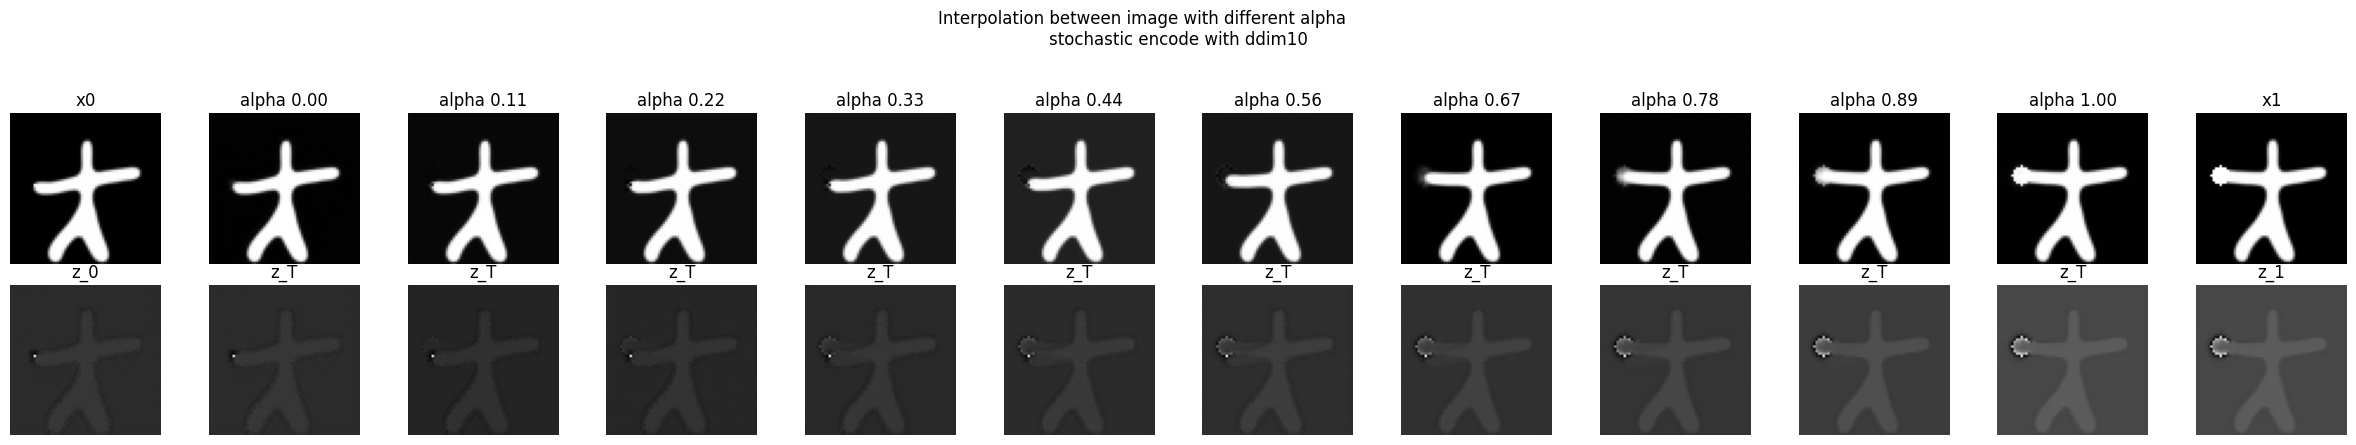

In [441]:
ncol = len(x_interpolated) + 2
nrow = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(2. * ncol, 2.1 *nrow))

# x0 image
ax = axes[0, 0]
ax.imshow(x0.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x0")

ax = axes[1, 0]
ax.imshow(out["z_0"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_0")

# x1 image
ax = axes[0, -1]
ax.imshow(x1.squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("x1")

ax = axes[1, -1]
ax.imshow(out["z_1"].squeeze(), cmap="gray")
ax.axis("off")
ax.set_title("z_1")

# interpolation image
for i, img in enumerate(x_interpolated):
    
    ax = axes[0, i+1]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"alpha {alpha[i]:.2f}")

    ax = axes[1, i+1]
    ax.imshow(zT[i].squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"z_T")

plt.suptitle(f"Interpolation between image with different alpha \
             \nstochastic encode with {ddim_style}", y=1.05)
plt.tight_layout()
plt.show()